# Advanced models: SVM, DecisionTrees, Randomforest

## Date: Nov 21, 2023

---------------

## Introduction

Having fit a baseline log reg, the next iteration is a SVM model. This model was chosen for variety, as log reg is probability based and SVM's distance based. It also offers relatively high explainability, and can be linear like log reg. However, it is very slow, espcially for non linear kernals. The training process of SVMs has a time complexity of O(n^3) and a space complexity of O(n^2), where n is the size of the training dataset.   
Note:  
- SVM's are very slow, especially non linear ones. Running the models may take over an hour. The sklearnex patch_sklearn() below has helped tremendously.  
  
Credit and more info:   
https://typeset.io/questions/why-does-svm-slow-to-train-17ziudq6fi

---------------

### Table of Contents

1. [Introduction](#Introduction)
   - [Table of Contents](#Table-of-contents)
   - [Import Librarys](#Import-Librarys)
   - [Data Dictionary](#Data-Dictionary)
   - [Load the data](#Load-the-Data)
2. [SVM Model](#SVM-Model)
   - [Assumptions](#Assumptions)
   - [PreProcessing](#PreProcessing)
   - [1st Iteration](#1st-Iteration)
   - [2nd Iteration](#2nd-Iteration)
3. [Conclusion](#Conclusion)


### Import Librarys

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.utils import resample
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

from tempfile import mkdtemp
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
from sklearnex import patch_sklearn 

from joblib import dump
from helpers import display_corr_heatmap, data_dict

Sklearnex will be used to speed up the sklearn library. It seems to work with AMD. If any bugs occur, simply comment out the code below.

In [2]:
#accelerate sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Data Dictionary

In [3]:
data_dict()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


### Load the Data

In [4]:
# Define the relative path to the file
parquet_file_path = Path('../Data/Lending_club/model_cleaned')

try:
    # Read the parquet file
    loans_df = pd.read_parquet(parquet_file_path)
except FileNotFoundError as e:
    print(e.args[1])
    print('Check file location')

In [5]:
loans_df.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
50867,23000.0,36,12.05,764.479980,3.0,RENT,50000.0,Source Verified,1,debt_consolidation,13.900000,0.0,1.0,8.0,0.0,9976.0,45.599998,12.0,0.0,Individual,0.0,0.0,11973.0,21900.0,2.0,1710.0,11924.0,45.599998,0.0,0.0,110.0,119.0,5.0,5.0,0.0,5.0,2.0,4.0,4.0,4.0,6.0,5.0,5.0,7.0,4.0,8.0,0.0,1.0,81.800003,0.000000,0.0,0.0,28207.0,11973.0,21900.0,6307.0
373353,35000.0,60,17.57,880.609985,2.0,RENT,110000.0,Verified,1,debt_consolidation,31.629999,0.0,0.0,27.0,0.0,50450.0,75.599998,38.0,0.0,Individual,0.0,541.0,304808.0,66700.0,3.0,11289.0,9169.0,81.599998,0.0,0.0,138.0,193.0,11.0,3.0,1.0,47.0,0.0,7.0,10.0,8.0,13.0,17.0,14.0,19.0,10.0,27.0,0.0,3.0,91.900002,50.000000,0.0,0.0,336948.0,215616.0,49900.0,134250.0
185185,33100.0,36,13.99,1131.119995,1.0,MORTGAGE,72000.0,Source Verified,1,debt_consolidation,12.130000,0.0,2.0,10.0,0.0,16993.0,37.599998,29.0,0.0,Individual,0.0,89.0,33172.0,45200.0,3.0,3686.0,8802.0,64.800003,0.0,0.0,143.0,247.0,10.0,10.0,0.0,43.0,0.0,3.0,4.0,3.0,9.0,7.0,9.0,22.0,4.0,10.0,0.0,1.0,100.000000,33.299999,0.0,0.0,67371.0,33172.0,25000.0,22171.0
33164,1000.0,36,11.22,32.849998,10.0,RENT,40000.0,Verified,1,vacation,18.270000,0.0,1.0,9.0,0.0,12175.0,39.799999,13.0,0.0,Individual,0.0,0.0,25333.0,30600.0,5.0,2815.0,17325.0,41.299999,0.0,0.0,19.0,132.0,1.0,1.0,0.0,1.0,0.0,4.0,4.0,6.0,8.0,2.0,7.0,11.0,4.0,9.0,0.0,3.0,100.000000,16.700001,0.0,0.0,46125.0,25333.0,29500.0,15525.0
368586,4400.0,36,12.29,146.759995,3.0,RENT,34000.0,Verified,1,debt_consolidation,8.860000,0.0,0.0,6.0,0.0,10915.0,78.000000,17.0,0.0,Individual,0.0,0.0,10915.0,14000.0,0.0,2183.0,1985.0,84.599998,0.0,0.0,123.0,172.0,29.0,29.0,0.0,33.0,0.0,4.0,4.0,4.0,9.0,3.0,6.0,14.0,4.0,6.0,0.0,0.0,100.000000,100.000000,0.0,0.0,14000.0,10915.0,12900.0,0.0


## SVM Model

Similarly to log reg, SVM creates linear boundaries. However, SVM aims to to maximize the decision boundary distance between classes, while minimizing misclassified data points. This increased buffer created between classes should better capture the extra variance when being evaluated on the test set. 

As SVM is a linear model at heart, it is assumed that the data is linearly separable (to some degree atleast) and that there is no colinearity or multicolinearity. These linear considerations can be relaxed somewhat for the non linear kernals, however the linear assumptions that were applied to log reg will be checked here as well. In addition, since SVM's use support vectors that greatly affect the hyperplanes orientation in space, they are more suseptable to outliers. For this reason, a median and IQR based scaler will be tried along the standard scaler.   
The hyper parameters to be used will be used:

- C value: The C hyperparameter tells the SVM optimization how much to avoid misclassifying each training example. For very large C values, the SVM will fit the training data very closely and tends to find a very small margin in favor of making fewer mistakes. 
For very small C values, the SVM will be allowed to pick a wider margin by misclassifying more point. Since accuracy is preferred for this project, a higher C value is going to be preferred, without overfitting.
- Scaler: As SVM is distance based, it will benefit from distance scaling. 
- Kernal: Multiple kernals will be used, including non linear and linear kernals. 

More information on SVM's:  
https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989s

### Assumptions

### Colinearity / Multicollinearity

Plot a correlation heatmap for the remaining features.

C:\Users\pags\.conda\envs\loans_capstone\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


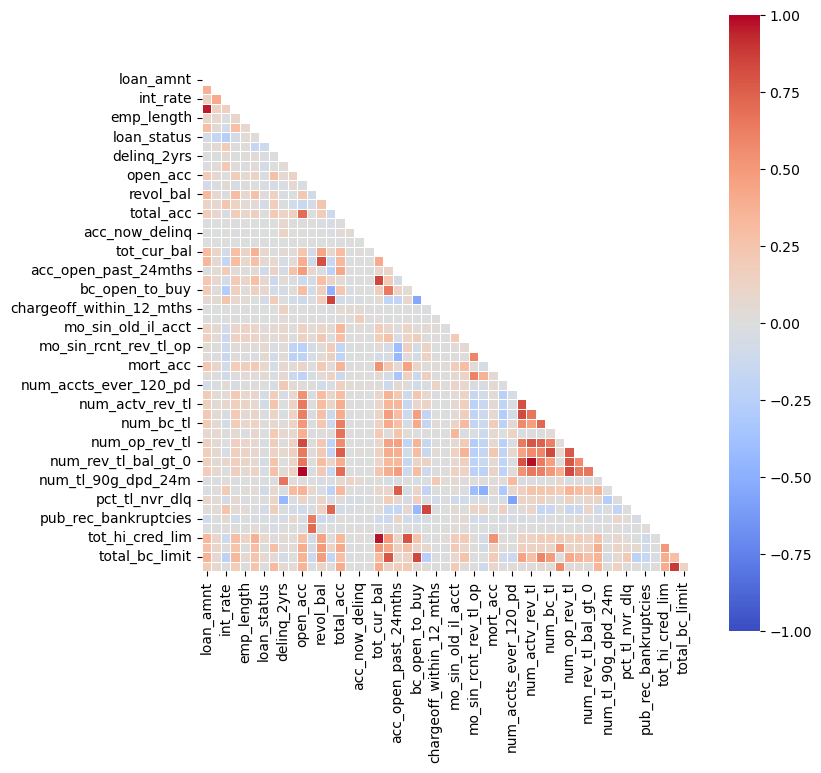

In [6]:
display_corr_heatmap(loans_df)

Check for multicollinearity and collineartiy before splitting the data or encoding categorical variables. First check for multicollinearity using Variance Inflation Factor (VIF). 

In [7]:
numeric_df = loans_df.select_dtypes(include=[np.number])

# Define a vif threshold
vif_cutoff = 10

# Create a dataframe to hold the vif scores for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = numeric_df.columns

In [ ]:
%%time
# Calculate the vif. This may take a few minutes
print('Running vif calculations ...')
vif_data['VIF'] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]
print('Finished vif calculations')

Running vif calculations ...


In [ ]:
# Sort vif's in descending order
vif_data.sort_values(by=['VIF'], ascending=False)

# Filter columns with a vif greater than the cutoff and place in a list
high_vif_columns = vif_data[vif_data['VIF'] > vif_cutoff]['feature'].tolist()
display(high_vif_columns)

In [ ]:
# Drop features with high VIF
# https://easystats.github.io/performance/reference/check_collinearity.html#:~:text=Interpretation%20of%20the%20Variance%20Inflation%20Factor&text=A%20VIF%20less%20than%205,model%20predictors%20(James%20et%20al.
filtered_high_vif_columns = [feature for feature in high_vif_columns if feature not in ['loan_amnt', 'term', 'int_rate']]

loans_df.drop(columns = filtered_high_vif_columns, inplace=True)

The remaining features:

In [ ]:
loans_df.head(0)

In [ ]:
display_corr_heatmap(loans_df)

### Preprocessing

***Train test split***

In [ ]:
# Split the data
X = loans_df.drop(columns=['loan_status'], inplace=False)
y = loans_df['loan_status']

# Split into train and test sets. Stratify to ensure any inbalance is preserved as in the original data. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11, stratify=y)

***Data Inbalance***

As shown in the log reg and EDA notebooks, the data is inbalanced. For svm's class weights can be used to combat this, however, we have more than enough data to properly balance the datasets.

In [ ]:
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])

# Downsample majority class
X_downsampled, y_downsampled  = resample(X_train[y_train == 1],
                                   y_train[y_train == 1],
                                   replace=False,
                                   n_samples=X_train[y_train == 0].shape[0],
                                   random_state=1)

print('\nNumber of class 1 examples after:', X_downsampled.shape[0])

# Combine the downsampled successful loans with the failed loans. Will keep as a df since changing to 
X_train_bal = pd.concat([X_train[y_train == 0], X_downsampled])
y_train_bal = np.hstack((y_train[y_train == 0], y_downsampled))

print("New X_train shape: ", X_train_bal.shape)
print("New y_train shape: ", y_train_bal.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

***Inspect Categorical Features***

Similarly to the log_reg model, categorical features will be encoded.

In [ ]:
categorical_columns = X_train_bal.select_dtypes('object').columns.tolist()
display(categorical_columns)
categorical_columns.remove('verification_status')

***Column Transformation***

In [ ]:
# Instantiate
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(categories=[['Not Verified', 'Source Verified', 'Verified']])

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ['home_ownership', 'verification_status', 'purpose', 'application_type']),
        ('ord', ordinal_transformer, ['verification_status'])],
    remainder='passthrough',
    n_jobs=2
)

# Fit to the train set
preprocessor.fit(X_train_bal)

# Transform the train and test sets
X_train_transformed = preprocessor.transform(X_train_bal)
X_test_transformed = preprocessor.transform(X_test)

print("Shape of train transformed: ", X_train_transformed.shape)
print("Shape of test transformed: ", X_test_transformed.shape)

### 1st Iteration

For the first iteration, the C value will be varied. This is the most important hyperparameter for SVM's. Manually iterating will give us a target range when we do the gridsearch, decreasing computation time and increasing the chance of finding the optimal hyperparameters.

In [ ]:
%%time

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

# Define a range of C values
C_values = [0.001, 0.01, 0.1, 1, 10, 100]

# Lists to store results
C_values_used = []
f1_scores = []
precision_scores_class_1 = []
train_accuracies = []
test_accuracies = []


# Loop through each C value
for C in C_values:

    print()
    print(f'Starting the loop for C value: {C}')
    
    # Fit an SVM model
    print('Fitting the model')
    model = SVC(C=C, kernel='linear', max_iter=800, verbose=1, cache_size=600, random_state=1)
    model.fit(X_train_scaled, y_train_bal)

    # Predict and evaluate
    print('Evaluating')
    y_pred_train = model.predict(X_train_scaled)
    y_pred = model.predict(X_test_scaled)
    
    report = classification_report(y_test, y_pred)
    
    # Get the specific scores out for class 1
    f1 = f1_score(y_test, y_pred, average='binary', pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1)
    
   # Calculate accuracies
    train_accuracy = accuracy_score(y_train_bal, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

    # Store results
    C_values_used.append(C)
    f1_scores.append(f1)
    precision_scores_class_1.append(precision)

    # Print the results
    print(f"C value: {C}")
    print(f"F1 Score for class 1: {f1}")
    print(f"Precision for class 1: {precision}")
    print()
    print("Classification Report:")
    print(report)
    print("---------------------------------------------------")

# Print summary of results
print("Finished training and evaluation.")
print("C values used:", C_values_used)
print("F1 Scores for class 1:", f1_scores)
print("Precision for class 1:", precision_scores_class_1)
print("Train Accuracies:", train_accuracies)
print("Test Accuracies:", test_accuracies)

In [ ]:
# Plotting the F1 Scores and Precision for class 1
plt.figure(figsize=(10, 6))

plt.plot(C_values_used, f1_scores, marker='o', label='F1 Score for class 1')
plt.plot(C_values_used, precision_scores_class_1, marker='x', linestyle='--', label='Precision for class 1')
plt.plot(C_values_used, train_accuracies, marker='*', linestyle='-', label='Train accuracy')
plt.plot(C_values_used, test_accuracies, marker='^', linestyle='-', label='Test accuracy')

plt.xscale('log')  # Since C values vary in orders of magnitude
plt.xlabel('C value')
plt.ylabel('Score')
plt.title('SVM Model Performance for Different C Values')
plt.legend()
plt.grid(True)
plt.show()

Looking at the graph, a range centered around 0.1 for C is likely to give the best results without overfitting. Although train and test accuracy are not suitable for inbalanced datasets, they are good markers for overfitting when compared between themselves. As C increases, the gap between test and train value widen, and accuracy generally decreases. Similarly, the peak for the class f1 score was at 0.01 - 0.1 and relatively stable, with precision peaking at 0.1.

Since precision is favoured, a range of 0.09 -> 0.1 -> 0.12 is suitable. Furthermore, there is little to no overfitting or underfitting. 

Note: Traditionally as C increases the model tends to overfit. However, in this case, it tends to underfit. This is likely due to random chance, as no cross validation was done, however it is good to note. 

### 2nd Iteration

We can now run an exhaustive gridsearch.  
The hyper parameters to be used will be:

'scaler': StandardScaler, RobustScaler  
'svm__C': 0.008, 0.01, 0.15  
'svm__kernel': 'linear', 'rbf'  
'svm__gamma': 'scale', 'auto'  
  
Minmax scaler wont be used as many of our features do not have clear bounded ranges, and it is suseptable to outliers. As seen in EDA, there were some features that had outliers, or had high leverage, so robustscaler will also be tried as it is less suseptable to outliers as it uses the median and IQR.   

More information on the different scalers can be found here:  
https://medium.com/@onersarpnalcin/standardscaler-vs-minmaxscaler-vs-robustscaler-which-one-to-use-for-your-next-ml-project-ae5b44f571b9

In [ ]:
%%time
# Temp cache for results for increased speed
cachedir=mkdtemp()

# Create a pipeline with a placeholder scaler and SVC
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Placeholder scaler
    ('svm', SVC(max_iter=1000, cache_size=600, random_state=1))], memory=cachedir)

# Define parameters
param_grid = {
    'scaler': [StandardScaler(), RobustScaler()],
    'svm__C': [0.09, 0.12],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto'],
}
# Create a GridSearchCV object
# Be sure to vary n_jobs based on cpu cores available
grid_search = GridSearchCV(pipe, param_grid, cv=5, verbose=2, n_jobs=3)

# Fit the grid search to the data
grid_search.fit(X_train_transformed, y_train_bal) 

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_transformed) 
y_train_pred = best_model.predict(X_train_transformed)

# Evaluate on training data
train_accuracy = accuracy_score(y_train_bal, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Evaluate on testing data
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


For the final iteration, we achieved a 0.83 precision, 0.62 recall, for a combined 0.71 f1 score. This is not quite as good as log reg, however, increasing max iter should help the model converge. As one would expect with the PDP plots from the log reg notebook, the non linear kernal outperformed the linear SVC. There is some overfitting still. 

***Save the best file***

In [ ]:
#relative path to models folder
model_file_path = Path('../Models/best_svm_model.joblib')
dump(best_model, model_file_path)

***Feature coef***

In [ ]:
# Get the feature weights out
feature_weights = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Coefficient': model.coef_[0]
})

# Sort the features by the absolute value of their coefficient
feature_weights = feature_weights.sort_values(by='Coefficient', ascending=True)

In [ ]:
# Plotting the feature weights
plt.figure(figsize=(10, 14))
plt.barh(feature_weights['Feature'], feature_weights['Coefficient'], color='lightblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

The features with the highest importance are were the application verification status (pertaining to income), and home ownership. Interestingly, having a home was negatively assocaiated withe the taget, although this can be speculated on why. 

## Conclusion

We explored SVM's, and experimented with different hyperparameters. Basic assumptions were explored and met before trying the first iteration. The c value was manually iterated over in order to find a suitable range from the gridsv. The final model underperformed log reg, and was far slower to calculate. Next we will explore decision trees. 